In [29]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from notebooks.imports import *
import re

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Config

In [30]:
from config import dir_config, main_config

raw_dir = Path(dir_config.data.raw)
processed_dir = Path(dir_config.data.processed)

mds_updrs_conf = main_config.MDS_UPDRS

### Import Data

In [31]:
session_metadata = pd.read_csv(Path(processed_dir, "processed_metadata_accu_60.csv"), index_col=None)

# replace categorical values with integers
session_metadata['Were_Diskinesias_Present'] = session_metadata['Were_Diskinesias_Present'].map({'yes': 1, 'no': 0})
session_metadata['Did_these_Movements_Interfere_with_Ratings'] = session_metadata['Did_these_Movements_Interfere_with_Ratings'].map({'yes': 1, 'no': 0})

In [32]:
all_subjects = session_metadata['subject_id'].unique()
stanford_subjects = session_metadata[session_metadata['experiment_site'] == 'Stanford']['subject_id'].unique()
ucla_subjects = session_metadata[session_metadata['experiment_site'] == 'UCLA']['subject_id'].unique()
case_western_subjects = session_metadata[session_metadata['experiment_site'] == 'Case_Western']['subject_id'].unique()

print(f"Total number of subjects: {len(all_subjects)}")
print(f"Number of subjects from Stanford: {len(stanford_subjects)}")
print(f"Number of subjects from UCLA: {len(ucla_subjects)}")
print(f"Number of subjects from Case Western: {len(case_western_subjects)}")


Total number of subjects: 16
Number of subjects from Stanford: 16
Number of subjects from UCLA: 0
Number of subjects from Case Western: 0


### Score Calculation

Calculate UPDRS, Tremor and Bradykinesia Scores

In [33]:
# Identify relevant tremor variables
relevant_UPDRS_vars = []
for var in mds_updrs_conf.UPDRS_ITEMS:
    assert var in session_metadata.columns, f"Variable {var} not found in DataFrame columns"
    relevant_UPDRS_vars.append(var)

# Identify relevant tremor variables
relevant_tremor_vars = []
for var in mds_updrs_conf.TREMOR_ITEMS:
    assert var in session_metadata.columns, f"Variable {var} not found in DataFrame columns"
    relevant_tremor_vars.append(var)

# Identify relevant bradykinesia variables
relevant_bradykinesia_vars = []
for var in mds_updrs_conf.BRADYKINESIA_ITEMS:
    assert var in session_metadata.columns, f"Variable {var} not found in DataFrame columns"
    relevant_bradykinesia_vars.append(var)

relevant_pigd_vars = []
for var in mds_updrs_conf.PIGD_ITEMS:
	assert var in session_metadata.columns, f"Variable {var} not found in DataFrame columns"
	relevant_pigd_vars.append(var)

# only for stanford_subjects
stanford_indices = session_metadata.index[session_metadata['subject_id'].isin(stanford_subjects)]

session_metadata.loc[stanford_indices, 'UPDRS'] = np.nansum(session_metadata.loc[stanford_indices, relevant_UPDRS_vars], axis=1)
session_metadata.loc[stanford_indices, 'tremor_score'] = np.nanmean(session_metadata.loc[stanford_indices, relevant_tremor_vars], axis=1)
session_metadata.loc[stanford_indices, 'bradykinesia_score'] = np.nanmean(session_metadata.loc[stanford_indices, relevant_bradykinesia_vars], axis=1)
session_metadata.loc[stanford_indices, 'pigd_score'] = np.nanmean(session_metadata.loc[stanford_indices, relevant_pigd_vars], axis=1)
session_metadata.loc[stanford_indices, 'brady_by_trem'] = session_metadata.loc[stanford_indices, 'tremor_score'] / session_metadata.loc[stanford_indices, 'bradykinesia_score']
session_metadata.loc[stanford_indices, 'pigd_by_trem'] = session_metadata.loc[stanford_indices, 'tremor_score'] / session_metadata.loc[stanford_indices, 'pigd_score']

In [34]:
# Function to assign label based on value and config
def get_label(value, thresholds):
    for label, (low, high) in thresholds.items():
        if low <= value <= high:
            return label
    return "unknown"

session_metadata.loc[stanford_indices, 'brady_vs_tremor_type'] = session_metadata.loc[stanford_indices, 'brady_by_trem'].apply(lambda x: get_label(x, mds_updrs_conf.TREM_VS_BRADY))
session_metadata.loc[stanford_indices, 'pigd_vs_tremor_type'] = session_metadata.loc[stanford_indices, 'pigd_by_trem'].apply(lambda x: get_label(x, mds_updrs_conf.TREM_VS_PIDG))


In [35]:
# Initialize column
session_metadata['trem_vs_non-trem'] = np.where(
    (session_metadata['brady_vs_tremor_type'] == 'tremor') |
    (session_metadata['pigd_vs_tremor_type'] == 'tremor'),
    'tremor',
    'non-tremor'
)

session_metadata['pigd_vs_non-pigd'] = np.where(session_metadata['pigd_vs_tremor_type'] == 'pigd', 'pigd', 'non-pigd')


In [36]:
# session_metadata['categorization'] = np.NaN
# session_metadata['trem_vs_brady'] = np.NaN
# session_metadata['trem_vs_pigd'] = np.NaN

# for sub in session_metadata['subject_id'].unique():
#     # get indices of the subject
#     idx = session_metadata[session_metadata['subject_id'] == sub].index
#     off_idx = session_metadata[(session_metadata['subject_id'] == sub) & (session_metadata['treatment'] == 'OFF')].index

#     if session_metadata.loc[off_idx, 'categorization_score'].values[0] <= 0.8:
#         session_metadata.loc[idx, 'categorization'] = 'bradykinesia_dominant'
#     elif session_metadata.loc[off_idx, 'categorization_score'].values[0] >= 1:
#         session_metadata.loc[idx, 'categorization'] = 'tremor_dominant'
#     elif 0.8 < session_metadata.loc[off_idx, 'categorization_score'].values[0] < 1:
#         session_metadata.loc[idx, 'categorization'] = 'intermediate'


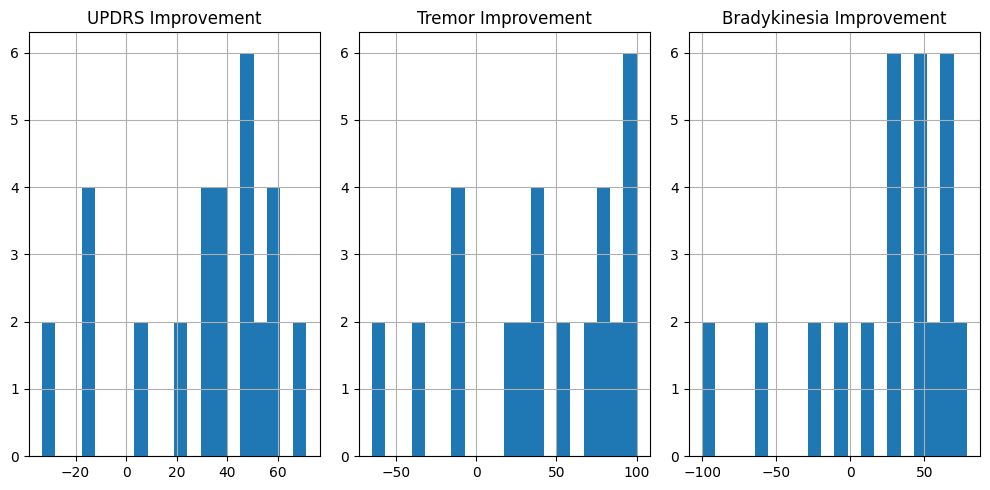

In [37]:
# Ensure improvement columns exist
session_metadata["UPDRS_improvement"] = np.nan
session_metadata["tremor_improvement"] = np.nan
session_metadata["bradykinesia_improvement"] = np.nan

for sub in session_metadata['subject_id'].unique():
    sub_data = session_metadata[session_metadata['subject_id'] == sub]
    if sub_data['treatment'].nunique() < 2:
        continue  # skip if both OFF and ON not present

    try:
        off_row = sub_data[sub_data['treatment'] == 'OFF'].iloc[0]
        on_row = sub_data[sub_data['treatment'] == 'ON'].iloc[0]

        def percent_improvement(off, on):
            return np.nan if off == 0 else (off - on) * 100 / off

        ui = percent_improvement(off_row['UPDRS'], on_row['UPDRS'])
        ti = percent_improvement(off_row['tremor_score'], on_row['tremor_score'])
        bi = percent_improvement(off_row['bradykinesia_score'], on_row['bradykinesia_score'])

        session_metadata.loc[sub_data.index, 'UPDRS_improvement'] = ui
        session_metadata.loc[sub_data.index, 'tremor_improvement'] = ti
        session_metadata.loc[sub_data.index, 'bradykinesia_improvement'] = bi

    except (IndexError, KeyError, TypeError):
        continue  # skip subjects with missing or malformed data

# Plot histogram
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
session_metadata['UPDRS_improvement'].hist(bins=20, ax=ax[0])
ax[0].set_title('UPDRS Improvement')
session_metadata['tremor_improvement'].hist(bins=20, ax=ax[1])
ax[1].set_title('Tremor Improvement')
session_metadata['bradykinesia_improvement'].hist(bins=20, ax=ax[2])
ax[2].set_title('Bradykinesia Improvement')
plt.tight_layout()
plt.show()

In [38]:
# Getting indices of on and off treatment from same subject in processed metadata
treatment_idx_all = pd.DataFrame(columns=['subject', 'off', 'on'])

for idx, sub in enumerate(session_metadata['subject_id'].unique()):
    sub_df = session_metadata.loc[session_metadata['subject_id'] == sub]

    # put off treatment first column and on treatment second column one row at a time
    treatment_idx_all.loc[idx] = [sub, sub_df.loc[sub_df['treatment'] == 'OFF'].index[0], sub_df.loc[sub_df['treatment'] == 'ON'].index[0]]

all_subjects = treatment_idx_all['subject'].unique()

print(f"All subjects (n={len(all_subjects)}): {all_subjects}")


All subjects (n=16): ['P1' 'P3' 'P4' 'P6' 'P7' 'P9' 'P11' 'P12' 'P13' 'P17' 'P18' 'P19' 'P20'
 'P22' 'P23' 'P24']


### Assess scores

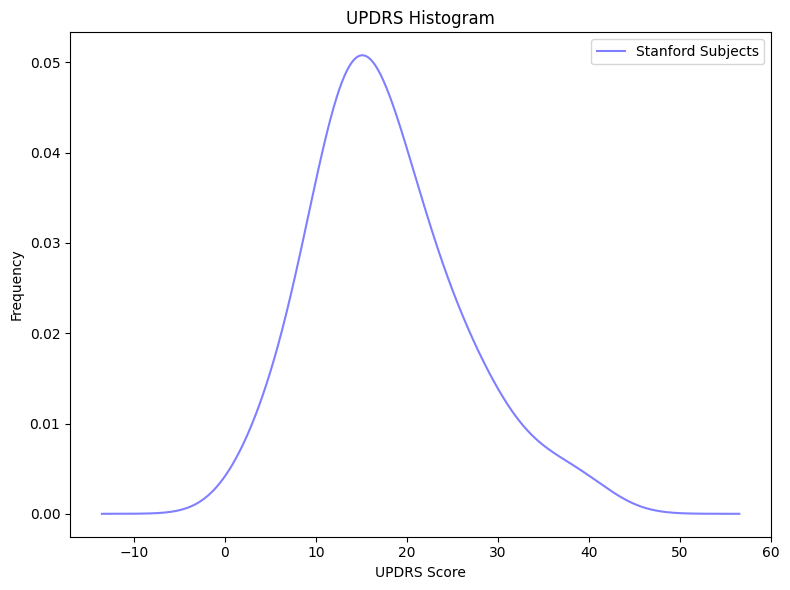

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

session_metadata.loc[session_metadata["subject_id"].isin(stanford_subjects), 'UPDRS'].plot(kind='kde', alpha=0.5, color='blue', ax=ax, label="Stanford Subjects")
# session_metadata.loc[session_metadata["subject_id"].isin(ucla_subjects), 'UPDRS'].plot(kind='kde', alpha=0.5, color='red', ax=ax, label="UCLA Subjects")

ax.set_title('UPDRS Histogram')
ax.set_xlabel('UPDRS Score')
ax.set_ylabel('Frequency')
ax.legend()

plt.tight_layout()
plt.show()


Subjects with higher UPDRS with medication: ['P4' 'P9' 'P12']


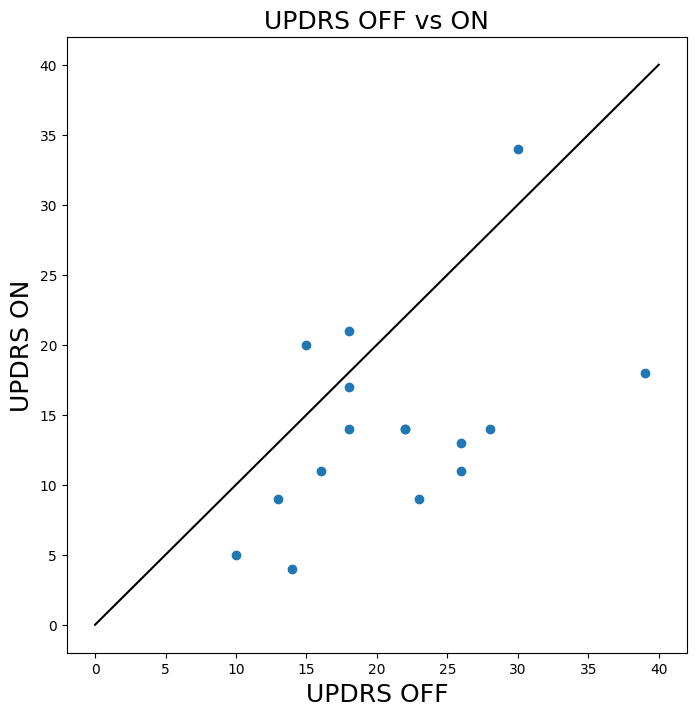

In [40]:

# get name of subjects where off UPDRS is greater than on UPDRS
print(f"Subjects with higher UPDRS with medication: {session_metadata.loc[treatment_idx_all['off'], 'subject_id'][(session_metadata.loc[treatment_idx_all['off'], 'UPDRS'].values < session_metadata.loc[treatment_idx_all['on'], 'UPDRS'].values)].values}")

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.plot(session_metadata.loc[treatment_idx_all["off"], 'UPDRS'], session_metadata.loc[treatment_idx_all["on"], 'UPDRS'], 'o')
plt.plot([0, 40], [0, 40], 'k-')
plt.xlabel('UPDRS OFF', fontsize=18)
plt.ylabel('UPDRS ON', fontsize=18)
plt.title('UPDRS OFF vs ON', fontsize=18)
plt.show()


(-0.1, 2.0)

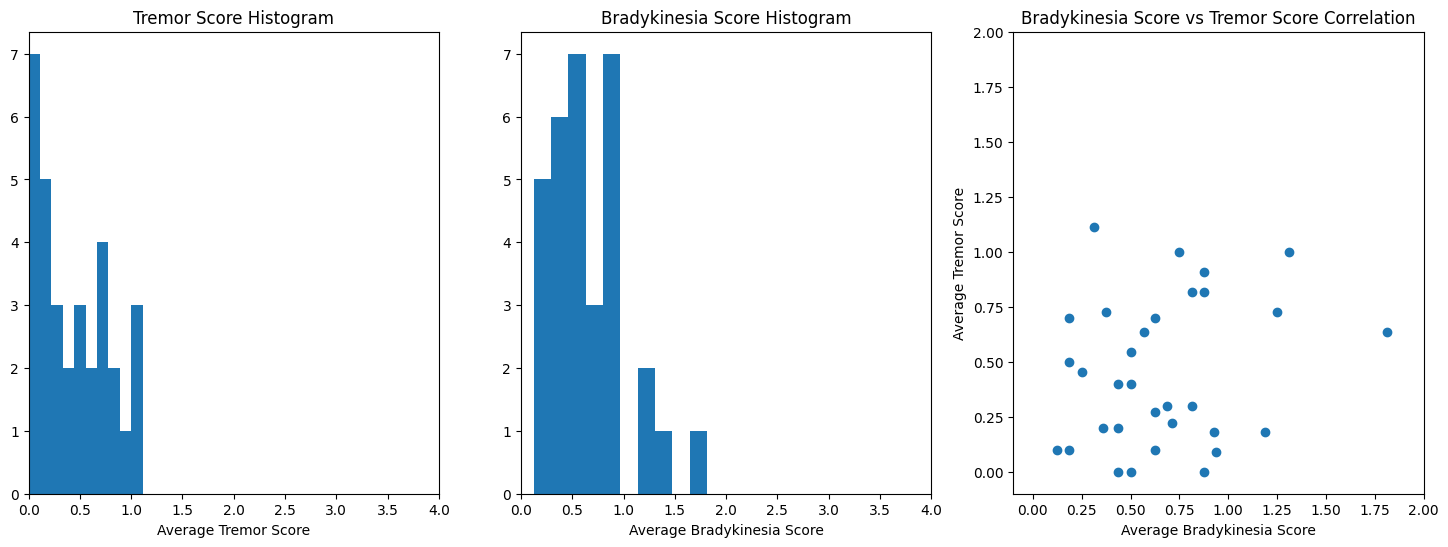

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].hist(session_metadata['tremor_score']),
ax[0].set_title('Tremor Score Histogram')
ax[0].set_xlabel('Average Tremor Score')
ax[0].set_xlim(0, 4)
ax[1].hist(session_metadata['bradykinesia_score'])
ax[1].set_title('Bradykinesia Score Histogram')
ax[1].set_xlabel('Average Bradykinesia Score')
ax[1].set_xlim(0, 4)
ax[2].plot(session_metadata['bradykinesia_score'], session_metadata['tremor_score'], 'o')
ax[2].set_title('Bradykinesia Score vs Tremor Score Correlation')
ax[2].set_xlabel('Average Bradykinesia Score')
ax[2].set_ylabel('Average Tremor Score')
ax[2].set_xlim(-0.1, 2)
ax[2].set_ylim(-0.1, 2)

### Save data and data results (metadata)

In [42]:
session_metadata.to_csv(Path(processed_dir, "processed_metadata_accu_60.csv"), index=False)